# Model Training Tutorial

Neural networks have set state of the art results across many domains such as computer vision, natural language processing, speech, etc. This tutorial focuses specifically on walking through how to train a model on a computer vision dataset for image classification.

We will be training the resnet50 architecture on fast.ai's [Imagenette dataset](https://github.com/fastai/imagenette) provided under the [Apache License 2.0](https://github.com/fastai/imagenette/blob/master/LICENSE). We will walk through exploring the dataset and training the resnet50 model on it. The resulting trained network can be used with our follow up scripts on performance. This baseline for the notebook is given such that it can be run with pytorch CPU or GPU in reasonable times (hours not days). If desired, you can substitute in other model architectures or datasets to work with.

In [1]:
import sys
import os

print('Python %s on %s' % (sys.version, sys.platform))

package_path = os.path.abspath(os.path.join(os.path.expanduser(os.getcwd()), os.pardir))
print(package_path)

"""
Adding the path to the neuralmagic-pytorch extension to the path so it isn't necessary to have it installed
"""
sys.path.extend([package_path])

print('Added current package path to sys.path')
print('Be sure to install from requirements.txt and pytorch separately')


Python 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]] on linux
/home/mark/neuralmagic/Shared/neuralmagicml-pytorch
Added current package path to sys.path
Be sure to install from requirements.txt and pytorch separately


## Dataset Selection

Now we walk through setting up a dataset for training. We default to the Imagenette dataset mentioned above where the original authors, much like ourselves, were interested in a dataset that has similar properties to more complicated datasets such as the Imagenet dataset but would allow rapid iterations. It includes 10 of the easiest classes out of the Imagenet 1000 dataset: tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute.

The dataset can easily be changed to the desired dataset in the code given.

Below we need to fill in the dataset path which will appear as a text input after running the next block. The dataset is setup to auto download in the specified folder if not found.

Additionally we will need to set the train and test batch sizes. The train batch size should generally be kept somewhere between 64 and 256 for proper convergence with stochastic gradient descent. A larger batch size allows us to average our updates over many examples to make sure we do not make a false step in the direction of noise. Too large of a batch size; however, can have a hindering effect as we end up smoothing our steps out too much effectively keeping us from exploring the optimization space. The test batch size, since we will not be updating weights in this mode, should be set to as high as possible for GPUs and does not matter much on pytorch CPU.

Finally, we will create three different datasets:
- Train dataset -- the data we iterate over and update the models weights using
- Validation dataset -- the data we use to make sure we are not overfitting (high variance) the training dataset
- Train Test dataset -- this one you may not be used to, we keep it here to evaluate a consistent measurement of performance metrics for the model to check for underfitting (high bias) and overfitting comparisons


In [2]:
import ipywidgets as widgets
import torch

print('\nEnter the local path where the dataset can be found')

dataset_text = widgets.Text(value='', placeholder='Enter local path to dataset', description='Dataset Path')
display(dataset_text)

print('\nChoose the batch size to run through the model during train and test runs')
print('(press enter if/after inputting manually)')
train_batch_size_slider = widgets.IntSlider(
    value=64, min=1, max=256, step=1, description='Train Batch Size:'
)
display(train_batch_size_slider)
test_batch_size_slider = widgets.IntSlider(
    value=64 if torch.cuda.is_available() else 1, min=1, max=256, step=1, description='Test Batch Size:'
)
display(test_batch_size_slider)


Enter the local path where the dataset can be found


Text(value='', description='Dataset Path', placeholder='Enter local path to dataset')


Choose the batch size to run through the model during train and test runs
(press enter if/after inputting manually)


IntSlider(value=64, description='Train Batch Size:', max=256, min=1)

IntSlider(value=64, description='Test Batch Size:', max=256, min=1)

In [3]:
from neuralmagicML.datasets import ImagenetteDataset, EarlyStopDataset
from torch.utils.data import Dataset, DataLoader

dataset_root = os.path.abspath(os.path.expanduser(dataset_text.value.strip()))
print('\nLoading dataset from {}'.format(dataset_root))

if not os.path.exists(dataset_root):
    raise Exception('Folder must exist for dataset at {}'.format(dataset_root))
    
train_batch_size = train_batch_size_slider.value
test_batch_size = test_batch_size_slider.value

print('\nUsing train batch size of {} and test batch size of {}\n'
      .format(train_batch_size, test_batch_size))
    
train_dataset = ImagenetteDataset(dataset_root, train=True, rand_trans=True)
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4)
print('train dataset created: \n{}\n'.format(train_dataset))

val_dataset = ImagenetteDataset(dataset_root, train=False, rand_trans=False)
val_data_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False, num_workers=4)
print('validation test dataset created: \n{}\n'.format(val_dataset))

train_test_dataset = EarlyStopDataset(ImagenetteDataset(dataset_root, train=True, rand_trans=False),
                                      early_stop=len(val_dataset))
train_test_data_loader = DataLoader(train_test_dataset, batch_size=train_batch_size, shuffle=False, num_workers=4)
print('train test dataset created: \n{}\n'.format(train_test_dataset))



Loading dataset from /home/mark/datasets/imagenette

Using train batch size of 256 and test batch size of 256

already downloaded imagenette of size ImagenetteSize.s160
train dataset created: 
Dataset ImagenetteDataset
    Number of datapoints: 12894
    Root location: /home/mark/datasets/imagenette/imagenette-160/train

already downloaded imagenette of size ImagenetteSize.s160
validation test dataset created: 
Dataset ImagenetteDataset
    Number of datapoints: 500
    Root location: /home/mark/datasets/imagenette/imagenette-160/val

already downloaded imagenette of size ImagenetteSize.s160
train test dataset created: 
Dataset ImagenetteDataset
    Number of datapoints: 500
    Root location: /home/mark/datasets/imagenette/imagenette-160/train



## Dataset Visualization

It's always a good idea to first visualize and understand the dataset checking for any issues such as noise, class imbalance, etc. 

Specifically we check the tran and validation dataset distributions. For training we want to make sure that all classes have relatively the same number of examples, if one is much less than others the most accurate path for the model will be to never predict it (why not if I can be right 80% of the time by just saying no!?). For validation we want to make sure that accuracy will be a valid measure of our performance. For unbalanced classes, and sometimes in general, we will need a substitute such as class-balanced accuracy, precision, recall, FScore, or AUC - ROC curves.

Additionally we visually inspect a random sample from the dataset to make sure the images represent what we would expect - classes are correct, lack of noise, etc. This helps us make sure that our data has a learnable distribution for the model. If it does not, we'll fail to converge and will need to go back and recollect the dataset.

Creating stats for validation dataset...

Validation dataset class counts
tench: 50
english springer: 50
cassette player: 50
chain saw: 50
church: 50
french horn: 50
garbage truck: 50
gas pump: 50
golf ball: 50
parachute: 50

Sample data plot


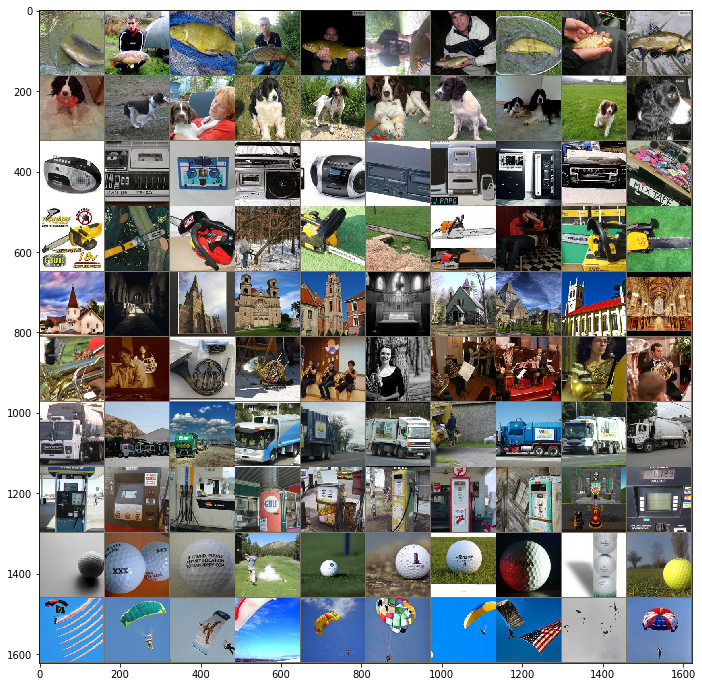


Creating stats for training dataset...

Train dataset class counts
tench: 1300
english springer: 1300
cassette player: 1300
chain saw: 1194
church: 1300
french horn: 1300
garbage truck: 1300
gas pump: 1300
golf ball: 1300
parachute: 1300


In [5]:
from collections import OrderedDict
import numpy
import matplotlib.pyplot as plt
from torchvision import utils, transforms


def plot_tensors_as_image(tensors, num_columns=10):
    inverse_transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-1 * 0.485, -1 * 0.456, -1 * 0.406], std=[1, 1, 1])
    ])
    image = tensors
    image = utils.make_grid(image, nrow=num_columns)
    plt.rcParams["figure.figsize"] = (12, 12)
    image = inverse_transform(image)
    image = image.numpy()
    plt.imshow(numpy.transpose(image, (1, 2, 0)))
    plt.show()


classes_map = OrderedDict({
    0: 'tench', 1: 'english springer', 2: 'cassette player',
    3: 'chain saw', 4: 'church', 5: 'french horn',
    6: 'garbage truck', 7: 'gas pump', 8: 'golf ball', 9: 'parachute'
})

print('Creating stats for validation dataset...')
val_classes_counts = OrderedDict({clazz: 0 for clazz in classes_map.values()})
val_samples = OrderedDict({clazz: [] for clazz in classes_map.values()})
for images, labels in val_data_loader:
    for image, label in zip(images, labels):
        label = label.item()
        clazz = classes_map[label]
        val_classes_counts[clazz] += 1
        
        if len(val_samples[clazz]) < 10:
            val_samples[clazz].append(image)
        
print('\nValidation dataset class counts')
for clazz, clazz_count in val_classes_counts.items():
    print('{}: {}'.format(clazz, clazz_count))

print('\nSample data plot')
plot_tensors_as_image(
    tensors=torch.stack([samp for class_samples in val_samples.values() for samp in class_samples]),
    num_columns=10
)

print('\nCreating stats for training dataset...')
train_classes_counts = OrderedDict({clazz: 0 for clazz in classes_map.values()})
for images, labels in train_data_loader:
    for image, label in zip(images, labels):
        label = label.item()
        clazz = classes_map[label]
        train_classes_counts[clazz] += 1
        
print('\nTrain dataset class counts')
for clazz, clazz_count in train_classes_counts.items():
    print('{}: {}'.format(clazz, clazz_count))


## Model Selection

For this exercise we'll create the standard [ResNet50 model](https://arxiv.org/abs/1512.03385) as it is simpler to visualize / understand and has good tradeoffs between accuracy and complexity of the model. The base implementation is setup for the imagenet dataset with 1000 classes and instead we'll be using the 10 in our dataset.

If you changed the dataset in the above cell then we'll need to update the number of classes to create the model with appropriately.

Additionally run the code block and select the device to run on before continuing. cpu runs in the pytorch cpu framework and cuda runs on an attached GPU.


In [6]:
import datetime
from neuralmagicML.models import resnet50

num_classes = 10
model = resnet50(num_classes=num_classes)
model_id = '{}-{}'.format(model.__class__.__name__,
                          datetime.datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
                              .replace('-', '.').replace(':', '.'))
print('Created model {}'.format(model.__class__.__name__))

print('\nChoose the device to run on')
device_choice = widgets.ToggleButtons(
    options=['cuda', 'cpu'] if torch.cuda.is_available() else ['cpu'],
    description='Device'
)
display(device_choice)


Created model ResNet

Choose the device to run on


ToggleButtons(description='Device', options=('cuda', 'cpu'), value='cuda')

## Loss, Metrics, Optimizer, and Logging

Below we go through setting up the loss function, metrics, optimizer, and additional logging. 

For the loss function we will use [cross entropy](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) as is standard for classification tasks. For additional metrics we will use the top 1 accuracy, ie did we predict the class correctly or not. We do this because there are only 10 classes available so top N accuracy is generally uninformative with so few classes. We use a custom wrapper class to organize the metrics and loss into one, callable class.

For the optimizer we will use [SGD + nesterov momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) with learning rate decay. The parameters for learning rate and learning rate decay were found over multiple training runs and perform well for ResNet50 and the Imagenette dataset. If working with a different dataset it may be a good idea to run a grid search to figure out the proper hyperparameters. Additionally, [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) may be substituted in at the cost of a little bit of validation accuracy.

Finally, beyond the usual basic screen-printouts let's use [tensorboard's](https://www.tensorflow.org/guide/summaries_and_tensorboard) nice logging capabilities. We'll primarily track scalars such as the loss and accuracy throughout training in this example. We use [tensorboardX](https://tensorboardx.readthedocs.io/en/latest/tensorboard.html) to log from pytorch into tensorboard. 


In [7]:
from torch import optim
from tensorboardX import SummaryWriter
from neuralmagicML.utils import TopKAccuracy, CrossEntropyLossWrapper


device = device_choice.value
model = model.to(device)
print('\nRunning on device {}'.format(device))

### optimizer and learning rate definitions
init_learning_rate = 0.1
lr_decay = 0.2 # divide lr by 5 every 'lr_decay_rate' epochs
lr_decay_rate = 20
momentum = 0.9
weight_decay = 1e-4
###

def adjust_learning_rate(optimizer, epoch):
    lr = init_learning_rate * (lr_decay ** ((epoch + 1) // lr_decay_rate))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return lr

optimizer = optim.SGD(model.parameters(), init_learning_rate, momentum=momentum,
                      weight_decay=weight_decay, nesterov=True)
print('\nCreated optimizer with initial lr: {}, momentum: {}, weight decay: {}'
      .format(init_learning_rate, momentum, weight_decay))

loss = CrossEntropyLossWrapper(extras={'top1acc': TopKAccuracy(1)})
print('\nCreated loss wrapper\n{}'.format(loss))

logs_dir = os.path.abspath(os.path.expanduser(os.path.join('.', 'model_training_logs', model_id)))

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

writer = SummaryWriter(logdir=logs_dir, comment='imagenette training')
print('\nCreated summary writer logging to \n{}'.format(logs_dir))



Running on device cuda

Created optimizer with initial lr: 0.1, momentum: 0.9, weight decay: 0.0001

Created loss wrapper
CrossEntropyLossWrapper(Loss: cross_entropy; Extras: TopKAccuracy)

Created summary writer logging to 
/home/mark/neuralmagic/Shared/neuralmagicml-pytorch/notebooks/model_training_logs/ResNet-2019.08.07.17.54.20


## Train Model

Now that our dataset, model, and optimizer is all setup we can begin training! The training cycle will be broken down into the following:

for number of epochs (an epoch is once through the training dataset:
   - train model over full training dataset (one epoch); update weights
   - test model over full validation dataset; no weight update
   - test model over sampled training dataset; no weight update

In the below code blocks, we create self-contained convenience functions for running the train and testing loops. These convenience functions are then called to train the model. At the end of the script we save the trained model in our current location with the date included as well as the final validation accuracy in the name.

Note, we have additionally created a logs directory next this script which, in combination with tensorboard, can be used to visualize the progress of the model. To launch tensorboard use the following command from within the notebooks directory:
'tensorboard --logdir model_training_logs --port 6006'
Now you will have an interactive dashboard running on [http://localhost:6006](http://localhost:6006)

In [ ]:
from tqdm import tqdm
from neuralmagicML.models import save_model


def test_epoch(model, data_loader, loss, device, epoch):
    model.eval()
    results = {}
    
    with torch.no_grad():
        for batch, (*x_feature, y_lab) in enumerate(tqdm(data_loader)):
            y_lab = y_lab.to(device)
            x_feature = tuple([dat.to(device) for dat in x_feature])
            batch_size = y_lab.shape[0]
            y_pred = model(*x_feature)
            losses = loss(x_feature, y_lab, y_pred)
            
            for key, val in losses.items():
                if key not in results:
                    results[key] = []
                result = val.detach_().cpu()
                result = result.repeat(batch_size)
                results[key].append(result)
                
    return results

def train_epoch(model, data_loader, optimizer, loss, device, epoch, writer):
    model.train()
    init_batch_size = None
    batches_per_epoch = len(data_loader)
    
    for batch, (*x_feature, y_lab) in enumerate(tqdm(data_loader)):
        y_lab = y_lab.to(device)
        x_feature = tuple([dat.to(device) for dat in x_feature])
        batch_size = y_lab.shape[0]
        if init_batch_size is None:
            init_batch_size = batch_size
        optimizer.zero_grad()
        y_pred = model(*x_feature)
        losses = loss(x_feature, y_lab, y_pred)
        losses['loss'].backward()
        optimizer.step(closure=None)
        
        step_count = init_batch_size * (epoch * batches_per_epoch + batch)
        for _loss, _value in losses.items():
            writer.add_scalar('Train/{}'.format(_loss), _value.item(), step_count)
            
print('Training model')
num_epochs = 90

for epoch in range(num_epochs):
    print('Starting epoch {}'.format(epoch))
    lr = adjust_learning_rate(optimizer, epoch)
    writer.add_scalar('Train/Learning Rate', lr, epoch)
    train_epoch(model, train_data_loader, optimizer, loss, device, epoch, writer)
    
    print('Completed training for epoch {}, testing validation dataset'.format(epoch))
    val_losses = test_epoch(model, val_data_loader, loss, device, epoch)
    for _loss, _values in val_losses.items():
        _value = torch.mean(torch.cat(_values))
        last_value = _value
        writer.add_scalar('Test/Validation/{}'.format(_loss), _value, epoch)
        print('{}: {}'.format(_loss, _value))
        
    print('Completed testing validation dataset for epoch {}, testing training dataset'.format(epoch))
    train_losses = test_epoch(model, train_test_data_loader, loss, device, epoch)
    for _loss, _values in train_losses.items():
        _value = torch.mean(torch.cat(_values))
        writer.add_scalar('Test/Training/{}'.format(_loss), _value, epoch)
        print('{}: {}'.format(_loss, _value))
        
    print('Completed testing training dataset for epoch {}'.format(epoch))
    
scalars_json_path = os.path.join(logs_dir, 'all_scalars.json')
writer.export_scalars_to_json(scalars_json_path)
writer.close()

save_path = os.path.abspath(os.path.expanduser(os.path.join('.', '{}-{}.pth'.format(model_id, last_value))))
print('Finished training, saving model to {}'.format(save_path))
save_model(save_path, model, optimizer, epoch)
print('Saved model')


  0%|          | 0/51 [00:00<?, ?it/s]

Training model
Starting epoch 0


  0%|          | 0/2 [00:00<?, ?it/s]

Completed training for epoch 0, testing validation dataset


  0%|          | 0/2 [00:00<?, ?it/s]

loss: 2.050513505935669
top1acc: 25.599994659423828
Completed testing validation dataset for epoch 0, testing training dataset


  0%|          | 0/51 [00:00<?, ?it/s]

loss: 2.144127607345581
top1acc: 20.999990463256836
Completed testing training dataset for epoch 0
Starting epoch 1


  0%|          | 0/2 [00:00<?, ?it/s]

Completed training for epoch 1, testing validation dataset


  0%|          | 0/2 [00:00<?, ?it/s]

loss: 1.9081915616989136
top1acc: 33.0
Completed testing validation dataset for epoch 1, testing training dataset


  0%|          | 0/51 [00:00<?, ?it/s]

loss: 1.9721633195877075
top1acc: 28.999980926513672
Completed testing training dataset for epoch 1
Starting epoch 2


  0%|          | 0/2 [00:00<?, ?it/s]

Completed training for epoch 2, testing validation dataset


  0%|          | 0/2 [00:00<?, ?it/s]

loss: 1.7399382591247559
top1acc: 38.99997329711914
Completed testing validation dataset for epoch 2, testing training dataset


  0%|          | 0/51 [00:00<?, ?it/s]

loss: 1.8791242837905884
top1acc: 33.200016021728516
Completed testing training dataset for epoch 2
Starting epoch 3


  0%|          | 0/2 [00:00<?, ?it/s]

Completed training for epoch 3, testing validation dataset


  0%|          | 0/2 [00:00<?, ?it/s]

loss: 1.7224478721618652
top1acc: 43.20000457763672
Completed testing validation dataset for epoch 3, testing training dataset


  0%|          | 0/51 [00:00<?, ?it/s]

loss: 1.798869013786316
top1acc: 40.600032806396484
Completed testing training dataset for epoch 3
Starting epoch 4


  0%|          | 0/2 [00:00<?, ?it/s]

Completed training for epoch 4, testing validation dataset


  0%|          | 0/2 [00:00<?, ?it/s]

loss: 1.3792457580566406
top1acc: 55.200035095214844
Completed testing validation dataset for epoch 4, testing training dataset


  0%|          | 0/51 [00:00<?, ?it/s]

loss: 1.5309252738952637
top1acc: 49.60002517700195
Completed testing training dataset for epoch 4
Starting epoch 5


  0%|          | 0/2 [00:00<?, ?it/s]

Completed training for epoch 5, testing validation dataset


  0%|          | 0/2 [00:00<?, ?it/s]

loss: 1.5238871574401855
top1acc: 48.79998779296875
Completed testing validation dataset for epoch 5, testing training dataset


  0%|          | 0/51 [00:00<?, ?it/s]

loss: 1.5867087841033936
top1acc: 49.5999755859375
Completed testing training dataset for epoch 5
Starting epoch 6


 57%|█████▋    | 29/51 [00:15<00:11,  1.89it/s]